# **Preprocessing and Modeling**

#### *Imports and Read in Data*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score, precision_score 
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
reddit = pd.read_csv('../data/reddit_cleaned.csv')
reddit.head(2)

,subreddit,author,selftext,created_utc,author_premium,is_video,score,title,upvote_ratio,num_comments,post_char_length,post_word_count
0,0,Jay_Subabove,"This batter is hitting .191 with 3HR, 12 RBI, ...",1655862592,False,False,1,Am I crazy?,1.0,0,263,53
1,0,Stress_Factor,"Not a Yankees fan, but modern day record looki...",1655856890,False,False,1,MLB Record (Wins),1.0,0,96,19


------
## Preprocessing

In [3]:
# using a function to remove html which seemed to be scattered throughout based on EDA
# this code was adapted from the breakfast hour NLP practice for week 5

def remove_html(post):
    '''function to remove html and lowercase all text'''
    post = post.lower()
    no_html = BeautifulSoup(post).text
    
    return no_html

In [4]:
reddit['clean_text'] = reddit['selftext'].apply(remove_html)
reddit.head(2)

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


,subreddit,author,selftext,created_utc,author_premium,is_video,score,title,upvote_ratio,num_comments,post_char_length,post_word_count,clean_text
0,0,Jay_Subabove,"This batter is hitting .191 with 3HR, 12 RBI, ...",1655862592,False,False,1,Am I crazy?,1.0,0,263,53,"this batter is hitting .191 with 3hr, 12 rbi, ..."
1,0,Stress_Factor,"Not a Yankees fan, but modern day record looki...",1655856890,False,False,1,MLB Record (Wins),1.0,0,96,19,"not a yankees fan, but modern day record looki..."


In [5]:
# creating functions that stem and lemmatize text - to be used as hyperparameters
# this code was adapted from the breakfast hour NLP practice for week 5
# lemmatize first

def lemmatize_post(post):
    '''
    Function splits the text data,
    lemmatizes it, and rejoins
    '''
    post_split = post.split()
    lemmatizer = WordNetLemmatizer()
    
    return " ".join([lemmatizer.lemmatize(word) for word in post_split])

In [6]:
# now for stemming

def stem_post(post):
    '''Same framework applied as lemmatize'''
    post_split = post.split()
    p_stemmer = PorterStemmer()
    
    return " ".join([p_stemmer.stem(word) for word in post_split])

------
## **Modeling**

In [7]:
# starting with simple models - just text column and default hyperparameters
# will tune once there appears to be a pipeline that works best

X = reddit['clean_text']
y = reddit['subreddit']

### **Defining the baseline accuracy**

In [8]:
y.value_counts(normalize=True)

1    0.500198
0    0.499802
Name: subreddit, dtype: float64

*hoping to beat the 50% baseline accuracy* (and ideally hit > 80% as defined in problem statement)

In [9]:
# splitting the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1889,)
(630,)


#### 1) Count Vectorizer and Naive Bayes (defaults)

In [11]:
# build the pipeline
pipe_cnb = Pipeline([
    ('cvec',CountVectorizer()),
    ('nb',MultinomialNB())])

In [284]:
pipe_cnb.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [285]:
print(f'Training accuracy: {pipe_cnb.score(X_train, y_train)}')
print(f'Test accuracy: {pipe_cnb.score(X_test, y_test)}')

Training accuracy: 0.771836950767602
Test accuracy: 0.6603174603174603


In [286]:
# heavily overfit

In [287]:
preds = pipe_cnb.predict(X_test)

# print the classification report after generating predictions
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       315
           1       0.67      0.64      0.65       315

    accuracy                           0.66       630
   macro avg       0.66      0.66      0.66       630
weighted avg       0.66      0.66      0.66       630



In [288]:
print(f'test score: {pipe_cnb.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

test score: 0.6603174603174603
F1 Score: 0.6525974025974025
Precision Score: 0.6677740863787376


#### 2) Tfidf Vectorizer and Naive Bayes (defaults)

In [289]:
# repeat the same process to train additional models (again with default parameters)
pipe_tnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tnb.fit(X_train, y_train)

print(f'Training accuracy: {pipe_tnb.score(X_train, y_train)}')
print(f'Test accuracy: {pipe_tnb.score(X_test, y_test)}')

Training accuracy: 0.7723663313922711
Test accuracy: 0.6682539682539682


In [290]:
# slightly worse accuracy and heavily overfit like before

In [291]:
preds = pipe_tnb.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       315
           1       0.68      0.63      0.66       315

    accuracy                           0.67       630
   macro avg       0.67      0.67      0.67       630
weighted avg       0.67      0.67      0.67       630



In [292]:
print(f'test score: {pipe_tnb.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

test score: 0.6682539682539682
F1 Score: 0.6556836902800658
Precision Score: 0.6815068493150684


#### 3) Count Vectorizer and Logistic Regression (defaults)

In [293]:
# repeat process with logistic regression
pipe_clog = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression())
])

pipe_clog.fit(X_train, y_train)

print(f'Training accuracy: {pipe_clog.score(X_train, y_train)}')
print(f'Test accuracy: {pipe_clog.score(X_test, y_test)}')

Training accuracy: 0.8941238750661725
Test accuracy: 0.726984126984127


In [294]:
# Still heavily overfit

In [295]:
preds = pipe_clog.predict(X_test)

print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')
print(' ')
print(classification_report(y_test, preds))

F1 Score: 0.7485380116959065
Precision Score: 0.6937669376693767
 
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       315
           1       0.69      0.81      0.75       315

    accuracy                           0.73       630
   macro avg       0.73      0.73      0.72       630
weighted avg       0.73      0.73      0.72       630



#### 4) Tfidf  Vectorizer and Logistic Regression (defaults)

In [296]:
# repeat process with logistic regression
pipe_tlog = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])

pipe_tlog.fit(X_train, y_train)

print(f'Training accuracy: {pipe_tlog.score(X_train, y_train)}')
print(f'Test accuracy: {pipe_tlog.score(X_test, y_test)}')

Training accuracy: 0.830068819481207
Test accuracy: 0.7253968253968254


In [297]:
# slightly less overfit but still less than ideal
preds = pipe_tlog.predict(X_test)

print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')
print(' ')
print(classification_report(y_test, preds))

F1 Score: 0.7258320126782885
Precision Score: 0.7246835443037974
 
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       315
           1       0.72      0.73      0.73       315

    accuracy                           0.73       630
   macro avg       0.73      0.73      0.73       630
weighted avg       0.73      0.73      0.73       630



#### 1a) Count Vectorizer and Naive Bayes (fine tune w GridSearch)

In [12]:
# build the pipeline
params_cnb = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [1,3,5,7,9],
    'cvec__ngram_range': [(1,1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
}

gs = GridSearchCV(pipe_cnb, param_grid=params_cnb, cv =3)
gs.fit(X_train, y_train)

# print out best score and best params
print(f'Best score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best score: 0.734784364196129
Best Parameters: {'cvec__max_df': 0.9, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}


In [13]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.8745367919534145
test score: 0.7
F1 Score: 0.7032967032967032
Precision Score: 0.6956521739130435


In [300]:
gs.score(X_test, y_test)
#also try stopwords, preprocessor (functions created earlier), tokenizer

0.7

#### 2a) Tfidf Vectorizer and Naive Bayes (fine tune w GridSearch)

In [14]:
# repeat the same process to train additional models (again with default parameters)
pipe_tnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

grid_params = {
    'tvec__max_df': [0.9, 0.95],
    'tvec__min_df': [1,3,5,7,9],
    'tvec__ngram_range': [(1,1), (1, 2)],
    'tvec__stop_words': [None, 'english'],
}

gs = GridSearchCV(pipe_tnb, param_grid = grid_params, cv = 3)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.755431902490726
Best Parameters: {'tvec__max_df': 0.9, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [15]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.880359978824775
test score: 0.7126984126984127
F1 Score: 0.717628705148206
Precision Score: 0.7055214723926381


In [303]:
# minor improvement

#### 3a) Count Vectorizer and Logistic Regression (fine tune w GridSearch)

In [334]:
# repeat process with logistic regression
pipe_clog = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression(max_iter = 10000))
])

clog_params = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [1,3,5,7,9],
    'cvec__ngram_range': [(1,1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
}

gs = GridSearchCV(pipe_clog,
                 param_grid= clog_params,
                 cv = 5)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.7877240256550602
Best Parameters: {'cvec__max_df': 0.9, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}


In [335]:
preds = gs.predict(X_test)
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

test score: 0.7206349206349206
F1 Score: 0.7404129793510326
Precision Score: 0.6914600550964187


#### 3b)

In [306]:
# try running again
pipe_clog = Pipeline([
    ('cvec', CountVectorizer(max_df=.9,min_df=1,ngram_range=(1,2), stop_words = 'english')), 
    ('log', LogisticRegression())
])

clog_params = {
   'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
}

gs = GridSearchCV(pipe_clog,
                 param_grid= clog_params,
                 cv = 5)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.7797833073695142
Best Parameters: {'cvec__max_features': 5000}


In [307]:
preds = gs.predict(X_test)
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

test score: 0.7238095238095238
F1 Score: 0.7441176470588236
Precision Score: 0.6931506849315069


#### 3c)

In [308]:
#consider different stopwords to use 
# Print English stopwords.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [309]:
stopword_list = stopwords.words('english')

In [310]:
new_words = ['removed', 'poll','https','com','www','reddit'] # pulled from EDA section
for i in new_words:
    stopword_list.append(i)

print(stopword_list)
stopword_list = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [336]:
# try running again
pipe_clog = Pipeline([
    ('cvec', CountVectorizer(max_df=.9,min_df=1,ngram_range=(1,2))), 
    ('log', LogisticRegression(max_iter = 10000))
])

clog_params = {
   'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__stop_words': [None, stopword_list]
}

gs = GridSearchCV(pipe_clog,
                 param_grid= clog_params,
                 cv = 5)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')

Best Score: 0.7797748866714385


In [337]:
preds = gs.predict(X_test)
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

test score: 0.7174603174603175
F1 Score: 0.7435158501440923
Precision Score: 0.6807387862796834


#### 4a) Tfidf  Vectorizer and Logistic Regression (fine tune w GridSearch)

In [16]:
pipe_tlog = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])

tlog_params = {
    'tvec__max_df': [0.9, 0.95],
    'tvec__min_df': [1,3,5,7,9],
    'tvec__ngram_range': [(1,1), (1, 2)],
    'tvec__stop_words': [None, 'english'],
}

gs = GridSearchCV(pipe_tlog,
                 param_grid=tlog_params,
                 cv = 3)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Best Parameters: {gs.best_params_}')

Best Score: 0.771319218378042
Best Parameters: {'tvec__max_df': 0.9, 'tvec__min_df': 9, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


In [17]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.8242456326098465
test score: 0.7301587301587301
F1 Score: 0.736842105263158
Precision Score: 0.7190332326283988


In [315]:
# still not getting close to the 80% threshold

------
## Changing Gears to Random Forest

#### 5)

In [42]:
# first attempt with CountVectorizer
rf = RandomForestClassifier(n_estimators=100)

pipe_cvrf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)) # setting random state to preproduce results
]) 

rf_params = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [1,3,5,7,9],
    'rf__n_estimators': [100, 150, 200, 250],
    'rf__max_depth': [1, 2, 3, 4, 5]}

gs = GridSearchCV(pipe_cvrf, rf_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7215459156635627


{'cvec__max_df': 0.9,
 'cvec__min_df': 5,
 'rf__max_depth': 5,
 'rf__n_estimators': 150}

In [43]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.7363684489147697
test score: 0.6682539682539682
F1 Score: 0.6759689922480621
Precision Score: 0.6606060606060606


In [44]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### 5a)

In [115]:
pipe_cvrf = Pipeline([
    ('cvec', CountVectorizer(max_df = 0.9, min_df = 9)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=43))
]) 

rf_params = {
    'cvec__ngram_range': [(1,1), (1, 2)],
    'cvec__stop_words': [None, 'english']
}

gs = GridSearchCV(pipe_cvrf, rf_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7427292839057545


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}

In [116]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.7580730545262043
test score: 0.7111111111111111
F1 Score: 0.7064516129032258
Precision Score: 0.7180327868852459


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


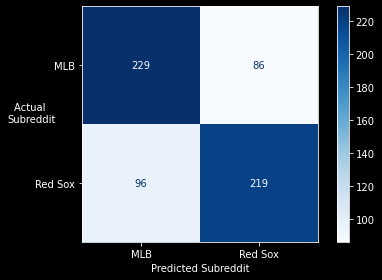

In [119]:
preds = gs.predict(X_test)
plot_confusion_matrix(estimator = gs, X = X_test, y_true = y_test,
                     cmap = 'Blues');
plt.xlabel('Predicted Subreddit')
plt.ylabel('Actual \nSubreddit', rotation=0)
plt.yticks(rotation = 'horizontal')

ax = plt.gca()
ax.set_xticklabels(['MLB', 'Red Sox'])
ax.set_yticklabels(['MLB', 'Red Sox']);

plt.style.use('dark_background')
# save for presentation
plt.tight_layout()
plt.savefig('../images/randomforest_confusion_dark.png')

#### 6) 

In [48]:
#try the same setup with tfidf
pipe_tvrf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state = 42))
]) 

rf_params = {
    'tvec__max_df': [0.9, 0.95],
    'tvec__min_df': [1,3,5,7,9],
    'rf__n_estimators': [100, 150, 200, 250],
    'rf__max_depth': [1, 2, 3, 4, 5]}

gs = GridSearchCV(pipe_tvrf, rf_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7236682060211472


{'rf__max_depth': 5,
 'rf__n_estimators': 150,
 'tvec__max_df': 0.9,
 'tvec__min_df': 5}

In [49]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.7511911064055056
test score: 0.6603174603174603
F1 Score: 0.669753086419753
Precision Score: 0.6516516516516516


#### 7)

In [51]:
# attempt with ExtremelyRandomizeTrees
# first attempt with CountVectorizer
pipe_cvet = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier(n_estimators=100,random_state=42))
]) 

et_params = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__min_df': [1,3,5,7,9],
    'et__n_estimators': [100, 150, 200, 250],
    'et__max_depth': [1, 2, 3, 4, 5]}

gs = GridSearchCV(pipe_cvet, et_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7088432970785913


{'cvec__max_df': 0.9,
 'cvec__min_df': 3,
 'et__max_depth': 5,
 'et__n_estimators': 150}

In [52]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.7130757014293276
test score: 0.6555555555555556
F1 Score: 0.6239168110918544
Precision Score: 0.6870229007633588


------
## Boosting

#### 8)

*AdaBoostClassifier*

In [53]:
# Try with CountVectorizer
ada_cpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42)))
])

ada_params = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
    'ada__n_estimators': [50, 100],
    'ada__base_estimator__max_depth': [1, 2],
    'ada__learning_rate': [.9, 1.0],
}

gs = GridSearchCV(ada_cpipe, param_grid = ada_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.755431902490726


{'ada__base_estimator__max_depth': 1,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 50,
 'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [54]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.7998941238750662
test score: 0.726984126984127
F1 Score: 0.7425149700598802
Precision Score: 0.7025495750708215


#### 9)

In [55]:
# Try with Tfidf Vectorizer
ada_tpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42)))
])

ada_params = {
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1, 2)],
    'tvec__stop_words': [None, 'english'],
    'ada__n_estimators': [50, 100],
    'ada__base_estimator__max_depth': [1, 2],
    'ada__learning_rate': [.9, 1.0],
}

gs = GridSearchCV(ada_tpipe, param_grid = ada_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7506657918422625


{'ada__base_estimator__max_depth': 1,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 50,
 'tvec__max_df': 0.9,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [56]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.8020116463737427
test score: 0.6936507936507936
F1 Score: 0.7165932452276065
Precision Score: 0.6666666666666666


*GradientBoostClassifier*

#### 10)

In [57]:
# Try with CountVectorizer
g_cpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('g', GradientBoostingClassifier(random_state=42))
])

ada_params = {
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
    'g__n_estimators': [50, 100],
    'g__learning_rate': [.9, 1.0],
}

gs = GridSearchCV(g_cpipe, param_grid = ada_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7617903617903617


{'cvec__max_df': 0.9,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'g__learning_rate': 0.9,
 'g__n_estimators': 100}

In [58]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.9010058231868714
test score: 0.734920634920635
F1 Score: 0.745814307458143
Precision Score: 0.716374269005848


#### 11)

In [59]:
# Try with Tfidf Vectorizer
g_tpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('g', GradientBoostingClassifier(random_state=42))
])

ada_params = {
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1,1), (1, 2)],
    'tvec__stop_words': [None, 'english'],
    'g__n_estimators': [50, 100],
    'g__learning_rate': [.9, 1.0],
}

gs = GridSearchCV(g_tpipe, param_grid = ada_params, cv = 3)
gs.fit(X_train, y_train)

print(gs.best_score_)
gs.best_params_

0.7390272625566743


{'g__learning_rate': 0.9,
 'g__n_estimators': 100,
 'tvec__max_df': 0.9,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [60]:
preds = gs.predict(X_test)
print(f'Training accuracy: {gs.score(X_train, y_train)}')
print(f'test score: {gs.score(X_test, y_test)}')
print(f'F1 Score: {f1_score(y_test, preds)}')
print(f'Precision Score: {precision_score(y_test, preds)}')

Training accuracy: 0.9025939650608787
test score: 0.7158730158730159
F1 Score: 0.7496503496503496
Precision Score: 0.67


-------
## Conclusions and next steps

We will plan to cast a wider net in this case by advertising on both the r/mlb and r/redsox, given we were not able to create a model that  accurately predict the correct subreddit at 80% (i.e. difficult to train a model that is able to discern between the two - so we'd rather cast a wider net across the subreddit channels. Despite not hitting the target accuracy and F1 scores of 80%, ran a sentiment analysis on the two subreddits. 

In [34]:
# Creat an instance of the Vader Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

# slice the df to just include the specific subreddits
redsox = reddit[reddit['subreddit'] == 1]
mlb = reddit[reddit['subreddit'] == 0]

# calculate the polarity score for each post and create a list of the compound scores that will provide average sentiment score
print('Red Sox mean sentiment:',np.mean([sent.polarity_scores(i)['compound'] for i in redsox['selftext']]))
print('MLB mean sentiment:',np.mean([sent.polarity_scores(i)['compound'] for i in mlb['selftext']]))

Red Sox mean sentiment: 0.14174896825396827
MLB mean sentiment: 0.2501284352660842


Both positive which is good to know - MLB may be more receptice to ads - and given how similar the sentiments are, makes the case to cast wider net by advertising 